In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
############## sys imports #############
import os
import sys
import time
import copy
import argparse
import datetime
############## basic stats imports #############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
############## pytorch imports #############
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader

In [3]:
############## custom imports #############
from dataloader import FaceScrubDataset, TripletFaceScrub, SiameseFaceScrub
from dataloader import FaceScrubBalancedBatchSampler

from networks import *
from losses import OnlineTripletLoss
from openface.loadOpenFace import prepareOpenFace
from utils import save_checkpoint, save_hyperparams, AverageMeter, HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector

In [4]:
# DATA_PATH = '/home/s1791387/facescrub-data/new_data_max/'
# DATA_PATH = '/home/var/final-fs-data/'
DATA_PATH = './new_data/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train_full_with_ids.txt')
VALID_PATH = os.path.join(DATA_PATH, 'val_full_with_ids.txt')
TEST_PATH = os.path.join(DATA_PATH, 'test_full_with_ids.txt')
# WEIGHTS_PATH = '/home/s1791387/facescrub-data/new_data_max/openface_model_weigths/job_semi_std_cos3_Jul_25_1000hrs/weights_75.pth'

In [5]:
batch_size = 512
input_size = 96
output_dim = 128
learning_rate = 1e-3
num_epochs = 10
start_epoch = 0

triplet_margin = 1.  # margin
triplet_p = 2  # norm degree for distance calculation

resume_training = False
workers = 4
use_cuda = True

In [6]:
cuda = False
pin_memory = False
if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))
print('Training set path: {}'.format(TRAIN_PATH))
print('Training set Path exists: {}'.format(os.path.isfile(TRAIN_PATH)))

Device set: cpu
Training set path: ./new_data/train_full_with_ids.txt
Training set Path exists: True


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}


train_df = FaceScrubDataset(
    txt_file=TRAIN_PATH, root_dir=DATA_PATH, transform=data_transforms['val'])

val_df = FaceScrubDataset(
    txt_file=VALID_PATH, root_dir=DATA_PATH, transform=data_transforms['val'])

# siamese_train_df = SiameseFaceScrub(train_df, train=True)
# print('Train data converted to siamese form. Length: {}'.format(len(siamese_train_df)))

# siamese_val_df=SiameseFaceScrub(val_df, train=False)
# print('Validation data converted to siamese form. Length: {}'.format(
#     len(siamese_val_df)))

train_loader=torch.utils.data.DataLoader(
        train_df, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=workers)
print('Train loader created. Length of train loader: {}'.format(
        len(train_loader)))
    
val_loader=torch.utils.data.DataLoader(
        val_df, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=workers)
print('Val loader created. Length of train loader: {}'.format(
        len(val_loader)))



Train loader created. Length of train loader: 108
Val loader created. Length of train loader: 12


In [8]:
openface = prepareOpenFace(useCuda=cuda)
params = sum(p.numel() for p in openface.parameters() if p.requires_grad)
print('Number of params in network {}'.format(params))

# en_optimizer=optim.Adam(openface.parameters(), lr=learning_rate)

Sent model to GPU
Number of params in network 3733968


In [9]:
if resume_training:
    resume_weights=WEIGHTS_PATH
    if cuda:
        checkpoint=torch.load(resume_weights)
    else:
        # Load GPU model on CPU
        checkpoint=torch.load(resume_weights,
                                map_location=lambda storage,
                                loc: storage)

    start_epoch=checkpoint['epoch']
    openface.load_state_dict(checkpoint['state_dict'])
    en_optimizer.load_state_dict(checkpoint['optimizer'])
    best_loss = checkpoint['best_loss']
    # scheduler.load_state_dict(checkpoint['scheduler'])
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(
        resume_weights, checkpoint['epoch']))
#     for epoch in range(0, start_epoch):
#         en_scheduler.step()

In [10]:
if cuda:
    openface.cuda()
#     classifier.cuda()
    print('Sent model to gpu {}'.format(
        next(openface.parameters()).is_cuda))

Sent model to gpu True


In [8]:
train_df.names

array(['Adam Brody', 'Adam McKay', 'Adrien Brody', 'Al Pacino',
       'Alan Alda', 'Alan Arkin', 'Alan Rickman', 'Alec Baldwin',
       'Alexander Skarsgård', 'Alfred Molina', 'Amaury Nolasco',
       'Andy Garcia', 'Andy Richter', 'Andy Serkis',
       'Anthony Stewart Head', 'Antonio Banderas',
       'Arnold Schwarzenegger', 'Arnold Vosloo', 'Ashton Kutcher',
       'Ben Affleck', 'Ben McKenzie', 'Ben Stiller', 'Benicio Del Toro',
       'Bernard Hill', 'Bernie Mac', 'Bill Murray', 'Bill Nighy',
       'Billy Bob Thornton', 'Billy Boyd', 'Billy Burke', 'Billy Zane',
       'Brad Garrett', 'Brad Pitt', 'Bradley Cooper', 'Brendan Fraser',
       'Bruce Greenwood', 'Bruce Willis', 'Burt Reynolds', 'Cary Elwes',
       'Casey Affleck', 'Channing Tatum', 'Charlie Day', 'Charlie Sheen',
       'Chazz Palminteri', 'Chris Kattan', 'Chris Klein', 'Chris Noth',
       'Christian Bale', 'Christian Slater', 'Christopher Lloyd',
       'Christopher Reeve', 'Clint Eastwood', 'Clive Owen',
      

In [9]:
train_df.faces_frame.groupby('name').count().sort_values('person_id', ascending=False)

,image_id,face_id,url,bbox,sha256,gender,person_id
name,,,,,,,
America Ferrera,196,196,196,196,196,196,196
Simon Pegg,187,187,187,187,187,187,187
Michael Douglas,186,186,186,186,186,186,186
Colin Firth,183,183,183,183,183,183,183
Felicity Huffman,178,178,178,178,178,178,178
Steve Carell,178,178,178,178,178,178,178
Miranda Cosgrove,177,177,177,177,177,177,177
Daniel Day-Lewis,177,177,177,177,177,177,177
Neve Campbell,177,177,177,177,177,177,177


In [10]:
select_names = ['Colin Firth', 'Steve Carell', 'Bradley Cooper', 'Ben Affleck', 'Felicity Huffman', 'Miranda Cosgrove', 'Joan Collins', 'America Ferrera']

In [11]:
# names = np.random.choice(train_df.names, 3)
# select_names = ['Ben Affleck', 'Richard Gere', 'Josh Brolin', 'Ian Holm', 'Melissa Fumero', 'Chase Masterson', 'Selena Gomez', 'Peggy McCay']
names_to_indices = {n: np.where(train_df.faces_frame.name == n)[0] for n in select_names}
train = {}
test = {}
val = {}
for name, arr in names_to_indices.items():
    train_stop = int(.85*len(arr))
    val_stop = int(.93*len(arr))
    train[name] = arr[:train_stop]
    val[name] = arr[train_stop:val_stop]
    test[name] = arr[val_stop:]

name_to_gender = dict(zip(select_names, ['male', 'male', 'male', 'male', 'female', 'female', 'female', 'female']))
# names_to_indices, name_to_gender
train, test, val

({'Colin Firth': array([7347, 7348, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357,
         7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7367, 7368,
         7369, 7370, 7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379,
         7380, 7381, 7382, 7383, 7384, 7385, 7386, 7387, 7388, 7389, 7390,
         7391, 7392, 7393, 7394, 7395, 7396, 7397, 7398, 7399, 7400, 7401,
         7402, 7403, 7404, 7405, 7406, 7407, 7408, 7409, 7410, 7411, 7412,
         7413, 7414, 7415, 7416, 7417, 7418, 7419, 7420, 7421, 7422, 7423,
         7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434,
         7435, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445,
         7446, 7447, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456,
         7457, 7458, 7459, 7460, 7461, 7462, 7463, 7464, 7465, 7466, 7467,
         7468, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7478,
         7479, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489,
         7

In [12]:
for n in select_names:
    print(n)

Colin Firth
Steve Carell
Bradley Cooper
Ben Affleck
Felicity Huffman
Miranda Cosgrove
Joan Collins
America Ferrera


In [13]:
train_reps = []
val_reps = []
test_reps = []

train_names = []
val_names = []
test_names = []

train_names_num = []
val_names_num = []
test_names_num = []

train_gender = []
val_gender = []
test_gender = []

openface.eval()
k = 0
with torch.no_grad():
    for n in select_names:
        print('---{}----'.format(n))
        ind = train[n]
        k += 1
        for i in ind:
            img, label = train_df[i]
            img = img.to(device)
            img.unsqueeze_(0)
            encoding, _ = openface(img)
            train_reps.append(encoding[0].cpu().numpy())
            train_names_num.append(k)
            train_names.append(n)
            train_gender.append(name_to_gender[n])
            if i == 0: 
                print(i)
                
    for n in select_names:
        print('---{}----'.format(n))
        ind = val[n]
        k += 1
        for i in ind:
            img, label = train_df[i]
            img = img.to(device)
            img.unsqueeze_(0)
            encoding, _ = openface(img)
            val_reps.append(encoding[0].cpu().numpy())
            val_names_num.append(k)
            val_names.append(n)
            val_gender.append(name_to_gender[n])
            if i == 0: 
                print(i)
    for n in select_names:
        print('---{}----'.format(n))
        ind = test[n]
        k += 1
        for i in ind:
            img, label = train_df[i]
            img = img.to(device)
            img.unsqueeze_(0)
            encoding, _ = openface(img)
            test_reps.append(encoding[0].cpu().numpy())
            test_names_num.append(k)
            test_names.append(n)
            train_gender.append(name_to_gender[n])
            if i == 0: 
                print(i)

NameError: name 'openface' is not defined

NameError: name 's_train' is not defined

In [26]:
# y_name = pd.DataFrame(names)
y_train_num = pd.DataFrame(train_names_num)
s_train = pd.DataFrame(train_gender)
X_train = pd.DataFrame(train_reps)

y_val_num = pd.DataFrame(val_names_num)
s_val = pd.DataFrame(val_gender)
X_val = pd.DataFrame(val_reps)

y_test_num = pd.DataFrame(test_names_num)
s_test = pd.DataFrame(test_gender)
X_test = pd.DataFrame(test_reps)

In [15]:
def gender(x):
    if "female" in x:
        return 1
    else:
        return 0

s_train_num = s_train[0].apply(gender)
s_val_num = s_val[0].apply(gender)
s_test_num = s_test[0].apply(gender)

NameError: name 's_train' is not defined

In [65]:
y_name.to_csv('names_8.csv')
y_num.to_csv('names_num8.csv')
s.to_csv('gender_8.csv')
X.to_csv('reps_new8.csv')
s_num.to_csv('gender_num8.csv')

In [29]:
import matplotlib.cm as cm
plt.style.use('bmh')

In [55]:
colors = cm.Dark2(np.linspace(0, 1, len(select_names)))

In [56]:
colors

array([[0.10588235, 0.61960784, 0.46666667, 1.        ],
       [0.85098039, 0.37254902, 0.00784314, 1.        ],
       [0.45882353, 0.43921569, 0.70196078, 1.        ],
       [0.90588235, 0.16078431, 0.54117647, 1.        ],
       [0.4       , 0.65098039, 0.11764706, 1.        ],
       [0.90196078, 0.67058824, 0.00784314, 1.        ],
       [0.65098039, 0.4627451 , 0.11372549, 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ]])

In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [58]:
X_pca = PCA(n_components=50).fit_transform(X, X)
tsne = TSNE(n_components=2, init='random', random_state=0)
X_r = tsne.fit_transform(X)
# X_r = tsne.fit_transform(X_pca)

[0.10588235 0.61960784 0.46666667 1.        ] 1 Colin Firth
[0.85098039 0.37254902 0.00784314 1.        ] 2 Steve Carell
[0.45882353 0.43921569 0.70196078 1.        ] 3 Bradley Cooper
[0.90588235 0.16078431 0.54117647 1.        ] 4 Ben Affleck
[0.4        0.65098039 0.11764706 1.        ] 5 Felicity Huffman
[0.90196078 0.67058824 0.00784314 1.        ] 6 Miranda Cosgrove
[0.65098039 0.4627451  0.11372549 1.        ] 7 Joan Collins
[0.4 0.4 0.4 1. ] 8 America Ferrera


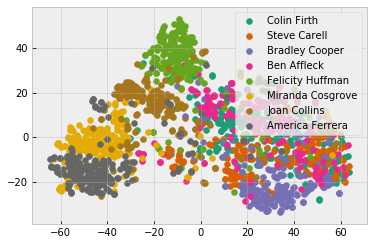

In [59]:
for c, i, target_name in zip(colors,
                             list(range(1, len(select_names) + 1)),
                             select_names):
    plt.scatter(X_r[(y_num == i)[0], 0], X_r[(y_num == i)[0], 1],
                c=c, label=target_name)
plt.legend()
plt.show()

In [60]:
out = "tsnedirect_new8.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: tsnedirect_new8.pdf


<Figure size 432x288 with 0 Axes>

In [61]:
colors = cm.Dark2(np.linspace(0, 1, 2))

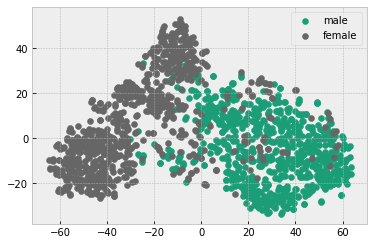

In [64]:
for c, target_name in zip(colors,
                             ['male', 'female']):
    plt.scatter(X_r[(s == target_name)[0], 0], X_r[(s == target_name)[0], 1],
                c=c, label=target_name)
plt.legend()
plt.show()

In [63]:
out = "tsnedirect_new8_gender.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: tsnedirect_new8_gender.pdf


<Figure size 432x288 with 0 Axes>

In [51]:
X_pca_gender = PCA(n_components=2).fit_transform(X, s_num)

In [52]:
X_pca_gender.shape

(976, 2)

In [53]:
X_pca_gender

array([[ 0.35575513, -0.02334388],
       [ 0.23660944, -0.10369195],
       [ 0.1450529 , -0.3687786 ],
       ...,
       [-0.48712095, -0.15050258],
       [ 0.70492446,  0.20068833],
       [-0.07966208, -0.36565251]])